# Exploring the Efficient Frontier

In [1]:
#Import Dependencies 
import requests, bs4, re, datetime, os, math, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# User Input
## Grab the User's preferences

To use default preferences, press enter repeatedly

In [2]:
#Regex to recognize dates
dateReg = re.compile(r'(\d\d?)/(\d\d?)/(\d\d\d\d)')
print('For default values, press enter without typing anything for all fields')
#Get User input for date
date = input('What date would you like to begin from? Please input in the form of dd/mm/yy -- ')
if date == '':
    date = datetime.date(1980, 12, 31)
else:
    while dateReg.search(date) == None:
        date = input('Error: Please input in the form of dd/mm/yyyy -- ')

#Repeat for the ending date
end = input('What date would you like to end at?\nTo choose today leave blank and press enter -- ')
if end == '':
    end = datetime.date.today()
else:
    while dateReg.search(end) == None:
        end = input('Error: Please input in the form of dd/mm/yyyy -- ')

#Interval Preference
interval = input('What frequency? - Options: are 1d, 1wk, and 1mo -- ')

if interval == '':
    interval = '1mo'
else:
    while interval not in ['1d','1wk', '1mo']:
        interval = input('Error:\nYou can only choose from 1d, 1wk, and 1mo -- ')
#Tickers
tickers = input('What tickers do you want to scrape? -- ')
if tickers == '':
    tickers = ['KO', 'PFE', 'MRNA', 'T', 'GE', 'F', 'GLD', 'MSFT', 'NVDA', 'MCD']
else:
    tickers = re.compile(r'\w+').findall(tickers)
    
limit = input('What is your MAXIMUM risk tolerance? (The program will find optimal values for all levels of risk up to and including this value) -- ')
if limit == '':
    limit = 25
else:
    while re.compile(r'\d+').search(limit) == None:
        limit = input('Error: Please input a number')
limit = int(limit)
xlim = limit


For default values, press enter without typing anything for all fields
What date would you like to begin from? Please input in the form of dd/mm/yy -- 31/1/2010
What date would you like to end at?
To choose today leave blank and press enter -- 31/1/2019
What frequency? - Options: are 1d, 1wk, and 1mo -- 1mo
What tickers do you want to scrape? -- KO T GLD TSLA AAPL F
What is your MAXIMUM risk tolerance? (The program will find optimal values for all levels of risk up to and including this value) -- 25


# Gather and Format data

In [3]:
def scrape(ticker, start, end, interval):
    global DataFrames

    #Convert dates to Datetime Objects
    if start != datetime.date(1980, 12, 31):
        day = int(dateReg.search(start).group(1))
        month = int(dateReg.search(start).group(2))
        year = int(dateReg.search(start).group(3))

        date = datetime.date(year, month, day)
        
    else:
        date = start
        
    if end != datetime.date.today():
        day = int(dateReg.search(end).group(1))
        month = int(dateReg.search(end).group(2))
        year = int(dateReg.search(end).group(3))

        end = datetime.date(year, month, day)

    #Convert dates to Yahoo date-codes

    beginning = datetime.date(1969, 12, 31) #The earliest date offered by Yahoo (Period Zero)
    delta = date - beginning

    startCode = delta.days * 86637
    endCode = startCode + (end - date).days * 86637

    #Pull Data
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={startCode}&period2={endCode}&interval={interval}&events=history&includeAdjustedClose=true'

    file = open('file.csv', 'w')
    res = requests.get(url)
    file.write(res.text)
    file.close()
    df = pd.read_csv('file.csv')
    os.remove('file.csv')

    lst = [0]
    i = 0
    before = df.iloc[0]['Adj Close']
    for row in df.iterrows():
        if i == 0: 
            i += 1
            continue
        change = 100 * ( (row[1]['Adj Close'] - before) / before )
        before = row[1]['Adj Close']
        lst.append(change)
    df['Adj Close'] = lst
    DataFrames.append(df)

In [4]:
#Execute the scrape function and compile into a master DataFrame

DataFrames = []

num = len(tickers)
for tick in tickers:
    try:
        scrape(tick, date, end, interval)
    except Exception as e:
        print(tick)
        print(str(e))
    

master = pd.DataFrame()

exes = []
wais = []
i = 0
for df in DataFrames:
    tick = tickers[i]
    frame = pd.DataFrame(df.set_index('Date')['Adj Close']).rename(columns= {'Adj Close': tick})
    master = master.merge(frame, left_index= True, right_index= True, how= 'outer')
    i += 1

master = master.dropna()
master.applymap(lambda x: str(round(x, 2)) + '%')

,KO,T,GLD,TSLA,AAPL,F
Date,,,,,,
2010-06-01,-2.49%,-0.45%,2.36%,0.0%,-2.08%,-14.07%
2010-07-01,11.83%,7.23%,-5.09%,-16.32%,2.27%,26.69%
2010-08-01,1.4%,6.03%,5.71%,-2.31%,-5.5%,-11.59%
2010-09-01,4.72%,5.81%,4.78%,4.77%,16.72%,8.41%
2010-10-01,6.38%,-0.28%,3.68%,7.01%,6.07%,15.44%
...,...,...,...,...,...,...
2018-11-01,5.26%,3.34%,0.34%,3.9%,-18.4%,0.3%
2018-12-01,-5.31%,-8.64%,4.94%,-5.04%,-11.36%,-18.7%
2019-01-01,1.65%,5.33%,2.89%,-7.75%,5.52%,15.03%


# Portfolio Analysis
We have generated a master DataFrame with price-change data
We can do classic portfolio analysis now

In [5]:
#Generate covariance matrix
cov = master.cov()
cov

,KO,T,GLD,TSLA,AAPL,F
KO,15.627307,5.797609,-0.142647,-3.039890,5.372633,6.944573
T,5.797609,20.160372,-0.839780,-13.698356,2.387281,4.037910
GLD,-0.142647,-0.839780,22.541114,2.374982,3.635103,0.184905
TSLA,-3.039890,-13.698356,2.374982,249.373720,4.352262,27.057018
AAPL,5.372633,2.387281,3.635103,4.352262,52.656696,13.137246
F,6.944573,4.037910,0.184905,27.057018,13.137246,59.215312


Before maximizing returns, we'll find the lowest risk portfolio

In [6]:
#Variance objective function to minimize
def variance(x):
    x = x.reshape(-1, 1)
    new = np.matmul(np.matrix(cov), np.matrix(x))
    return math.sqrt(np.dot(x.reshape(-1), new))
   
        
x = np.array([1/num] * num).reshape(-1, 1)

# Visualization through random simulation

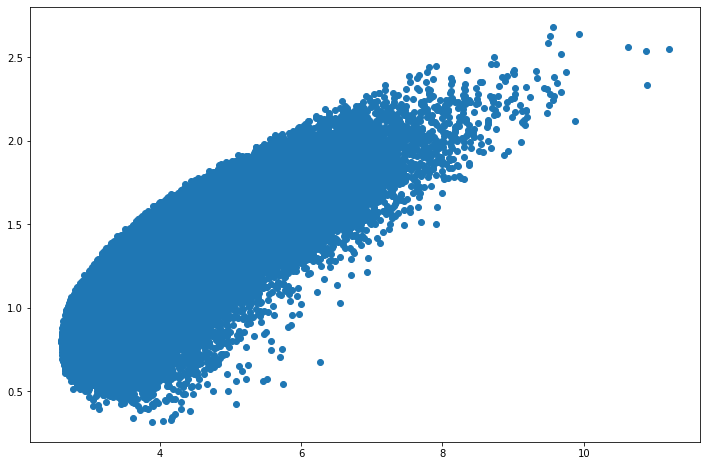

In [7]:
wais = []
exes = []
for _ in range(100000):
    x = np.random.rand(num, 1)
    x = x / np.sum(x)
    ret = np.dot(x.reshape(-1), master.mean())
    var = variance(x)
    exes.append(var)
    wais.append(ret)
   
plt.figure(figsize = (12, 8))
plt.scatter(exes, wais )
# plt.xticks([x for x in range(25)])
# plt.yticks([x for x in range(12)])
plt.show()

## The efficient frontier is beginning to take shape!

Let's find its exact shape with scipy's optimization package

In [8]:
#Define sum(weight) = 1 constraint for inputs
def weightCon(x):
    return 1 - np.sum(x)
constraint1 = {'type': 'eq', 'fun': weightCon}

#Define bounds for each stock's weight
b = (0, 1)
bounds = [b] * num
val = minimize(variance, x, constraints=[constraint1],  method='SLSQP', bounds= bounds)

minVar = val.fun

# Maximizing Returns
We have our minimum amount of risk
Now we know our lower-limit risk tolerance
We can maximize returns for any given variance 

In [9]:
#New Objective Function - Returns
def exRet(x):
    return (np.dot(x.reshape(-1), master.mean())) * -1

#New Constraint
def varCon(x):
    x = x.reshape(-1, 1)
    new = np.matmul(np.matrix(cov), np.matrix(x))
    std = math.sqrt(np.dot(x.reshape(-1), new)) 
    return (std - limit) * -1

constraint2 = {'type': 'ineq', 'fun': varCon}

In [10]:
#Loop through all possible risk tolerances (incrementing by .1) and find their optimal solution

limit = 25
exes = []
wais = []

#weight DataFrame dict
weights = {}
for tick in tickers:
    weights[tick] = []
  

def isIn(lst):
    for elem in lst:
        if round(elem, 2) == 1:
            return True
    return False
switch = 0
for i in range(limit * 10):
    
    #Increment
    limit = limit - .1
    
    #Stop condition
    if limit < minVar:
        break
     
    #Optimize
    val = minimize(exRet, x, constraints= [constraint1, constraint2], bounds= bounds, method= 'SLSQP')
    
    if isIn(val.x):
        continue
        
    else:
        if switch == 0:
            xlim = limit
            switch = 1
            
        
    #Record weights
    for a in range(len(tickers)):
        weights[tickers[a]].append(val.x[a])
    exes.append(limit)
    wais.append(val.fun * -1)
            
#Display Weights over time
weights = pd.DataFrame(weights).iloc[::-1]
weights = weights.reset_index()[tickers]

weights['var'] = exes[::-1]
weights = weights.set_index('var')


weights.applymap(lambda x: str(round(x * 100, 2)) + '%')
      

,KO,T,GLD,TSLA,AAPL,F
var,,,,,,
2.6,31.5%,27.44%,28.13%,4.52%,6.63%,1.79%
2.7,32.74%,27.87%,20.74%,6.93%,11.73%,0.0%
2.8,33.02%,27.89%,16.71%,8.1%,14.29%,0.0%
2.9,33.23%,27.91%,13.55%,9.03%,16.29%,0.0%
3.0,33.42%,27.92%,10.82%,9.82%,18.02%,0.0%
...,...,...,...,...,...,...
15.3,0.0%,0.0%,0.0%,96.82%,3.18%,0.0%
15.4,0.0%,0.0%,0.0%,97.47%,2.53%,0.0%
15.5,0.0%,0.0%,0.0%,98.12%,1.88%,0.0%


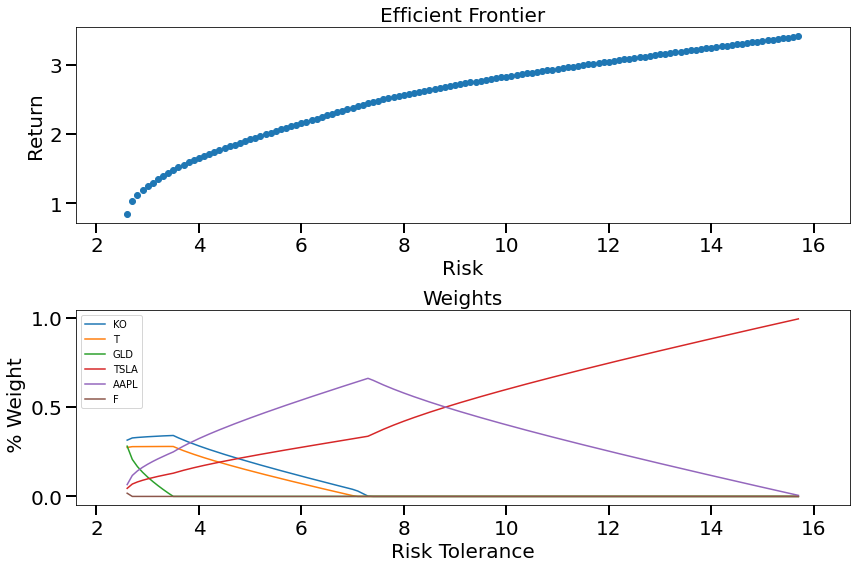

In [11]:
#Generate Plot

fig, axs = plt.subplots(2, figsize=(12, 8), sharex=True)

axs[0].scatter(exes, wais)
axs[0].set_xlabel('Risk', fontsize = 20)
axs[0].set_ylabel('Return', fontsize = 20)

axs[0].tick_params(axis="x", labelsize=20, width = 2, length = 10, labelbottom=True)
axs[0].tick_params(axis="y", labelsize=20, width = 2, length = 10)

axs[0].set_xlim(minVar - 1, xlim + 1)
axs[0].set_title('Efficient Frontier', fontsize=20)

axs[1].plot(weights)
# axs[1].set_xticks(axs[0].get_xticks())
axs[1].legend(weights.columns)
axs[1].set_title('Weights', fontsize= 20)
axs[1].tick_params(axis="x", labelsize=20, width = 2, length = 10)
axs[1].tick_params(axis="y", labelsize=20, width = 2, length = 10)
axs[1].set_xlabel('Risk Tolerance', fontsize = 20)
axs[1].set_ylabel(' % Weight', fontsize = 20)


plt.tight_layout()
plt.show()